In [3]:
import os
# ptb 모듈 경로 추가
import sys
sys.path.append('C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/밑바닥부터시작하는딥러닝2')

import numpy as np
from common.layers import SoftmaxWithLoss
from common.trainer import Trainer
from common.optimizer import Adam

In [4]:
class MatMul:
    def __init__(self, W):
        self.params = [W]               # 가중치 W를 인스턴스 변수 params에 리스트로 저장
        self.grads = [np.zeros_like(W)] # 기울기를 인스턴스 변수 grads에 리스트로 저장
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)      # dx는 dout과 W(가중치)의 전치행렬을 곱함       
        dW = np.dot(self.x.T, dout) # dW는 self.x(입력 데이터)의 전치행렬과 dout을 곱함
        self.grads[0][...] = dW
        return dx

In [5]:
C = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3) # 표준 정규분포로 가중치 초기화
layer = MatMul(W)
h = layer.forward(C)      # 순전파, C와 W의 행렬 곱은 가중치의 행벡터 하나를 선택하는 것과 같다.
print(h)

[[ 1.52819403 -1.05529792 -0.06280352]]


### CBOW 모델 추론 

In [6]:
c0 = np.array([1,0,0,0,0,0,0])
c1 = np.array([0,0,0,1,0,0,0])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1) # h0과 h1을 더한 후 0.5를 곱해 평균을 구한다.
s = out_layer.forward(h) # score 계산

print(s) # score 출력

[ 2.32654807  0.07738818  1.07534813 -1.12237924  1.72184394 -1.03750709
 -1.3340759 ]


### word2vec 학습  

In [7]:
# 맥락과 타깃 만들기 

# 1. 말뭉치 전처리 함수
def preprocess(text):
    text = text.lower()             # 소문자로 변환
    text = text.replace('.', ' .')  # 마침표를 공백과 마침표로 분리
    words = text.split(' ')         # 공백을 기준으로 분리
    
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [8]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)  # 말뭉치 전처리 함수 호출, 각 단어에 ID 부여
print(corpus)
print(word_to_id)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [9]:
# 2. 맥락과 타깃을 만드는 함수
def create_contexts_target(corpus, window_size=1): # window_size는 좌우로 몇 개의 단어를 볼 것인지를 정하는 매개변수
    target = corpus[window_size:-window_size]     # 타깃은 맥락의 양 끝에 해당하는 단어를 제외한 모든 단어
    contexts = []                                 # 맥락(입력 데이터)을 저장할 리스트
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [10]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts) # 맥락(입력 데이터) 출력
print(target)   # 타깃 출력

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [11]:
# 3. 단어 ID를 원핫 표현으로 변환하는 함수
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [12]:
vocab_size = len(word_to_id) # 어휘 수
target = convert_one_hot(target, vocab_size) # 타깃을 원핫 표현으로 변환
contexts = convert_one_hot(contexts, vocab_size) # 맥락을 원핫 표현으로 변환

In [13]:
target
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]])

In [14]:
# 4. CBOW 모델 구현
class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size                   # V는 어휘 수, H는 은닉층의 뉴런 수

    # 가중치 초기화
    W_in = 0.01 * np.random.randn(V, H).astype('f')  # 입력층 가중치, 0.01을 곱해 표준편차가 0.01인 정규분포로 초기화, f는 float32 자료형 즉 32비트 부동소수점, 크기는 V x H
    W_out = 0.01 * np.random.randn(H, V).astype('f') #  출력층 가중치, 크기는 H x V

    # 계층 생성
    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    # 소프트맥스 함수와 교차 엔트로피 오차 계층
    self.loss_layer = SoftmaxWithLoss()              

    # 모든 가중치와 기울기를 리스트에 모은다.
    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], [] # params 리스트는 가중치, grads 리스트는 기울기를 저장
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    # 인스턴스 변수에 단어의 분산 표현을 저장한다.
    self.word_vecs = W_in                     # W_in은 가중치 벡터인데, 즉 각 행에 대응하는 가중치 벡터가 단어의 분산 표현이다.
  
  # 순전파 계층 
  def forward(self, contexts, target):        # contexts는 3차원 넘파이 배열이라고 가정한다. 즉, (배치 크기, 맥락의 윈도우 크기, 어휘 수), target은 2차원 넘파이 배열이라고 가정한다. 즉, (배치 크기, 어휘 수)
    h0 = self.in_layer0.forward(contexts[:, 0]) # contexts의 첫 번째 열(인덱스 0)을 추출하여 첫 번째 MatMul 계층에 입력
    h1 = self.in_layer1.forward(contexts[:, 1]) # contexts의 두 번째 열(인덱스 1)을 추출하여 두 번째 MatMul 계층에 입력
    h = (h0 + h1) * 0.5                         # 두 MatMul 계층의 출력을 더하고 0.5를 곱해 평균을 구한다.
    score = self.out_layer.forward(h)           # 출력층의 MatMul 계층에 입력하여 점수를 출력
    loss = self.loss_layer.forward(score, target)
    return loss
  
  # 역전파 계층
  def backward(self, dout=1):                 # dout은 1로 설정한다. 역전파의 시작점이기 때문이다.
    ds = self.loss_layer.backward(dout)       # ds는 SoftmaxWithLoss 계층의 역전파 출력 값이다. 즉, 손실에 대한 기울기
    da = self.out_layer.backward(ds)          # ds를 MatMul 계층에 역전파하여 은닉층의 기울기를 구한다.
    da *= 0.5                                 # 은닉층의 기울기 da에 0.5를 곱해 나눈다.        
    self.in_layer1.backward(da)       
    self.in_layer0.backward(da)
    return None

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

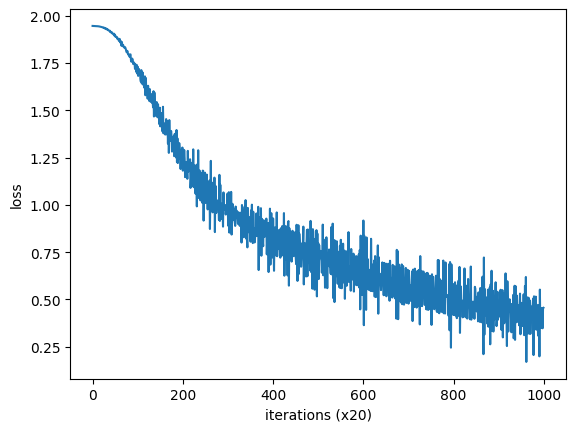

In [15]:
# 5. CBOW 모델 학습 코드
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# 말뭉치 전처리
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

# 맥락과 타깃 생성
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)

# 단어 ID를 원핫 벡터로 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 모델 생성
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)
# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [16]:
# 각 단어별 분산 표현 출력
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id]) # 단어 벡터 차원은 은닉층 노드 수와 같다.

you [-0.92804056  1.6870918   0.87930435 -0.8597527  -0.8794441 ]
say [ 1.1550536   0.37442717 -1.1611354   1.1350231   1.1513948 ]
goodbye [-1.0465043 -0.1689987  1.0506904 -1.0890825 -1.0542152]
and [ 0.7762996   1.8219686  -0.72407895  0.7663845   0.76105833]
i [-1.0336266  -0.17204405  1.0419595  -1.0982733  -1.0567404 ]
hello [-0.9265914   1.6890261   0.8763378  -0.8516353  -0.87260926]
. [ 1.2156078 -1.640434  -1.2415066  1.1934896  1.2306609]
